# Neural Network Hyperparameters

This tutorial provides code that helps experimenting with different neural network hyperparameters, including different learning rate schedulers.

In [64]:
# Import keras and other functionality
import tensorflow as tf
from tensorflow import keras
from tensorflow import random
from keras.callbacks import EarlyStopping, ModelCheckpoint

keras.backend.clear_session()
random.set_seed(42)

In [65]:
# Load Fashion MNIST fashion data
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

# Select 55,000 datapoints for training and 5,000 datapoints for validation
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [66]:
# Preprocess training and validation data
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Use early stopping to avoid wasting resources with unnecessary training. Training will stop if validation loss does not improve for 5 epochs (patience). Early stopping is done by using a callback object in Keras, as can be seen below:

In [67]:
# Early stopping (it uses Keras callbacks API)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback to save best model (according to validation loss)
name_model = 'keras_best_model.keras'
best_model = ModelCheckpoint(name_model, monitor='val_loss', mode='min', save_best_only=True)

# Callbacks for early stopping and saving best model
call_backs=[early_stopping, best_model]

Choose optimiser to use and corresponding learning rate. Here the learning rate is kept constant during training. Below you can see how to change the learning rate during training using learning rate schedulers.

In [68]:
# Choose optimiser (SGD, ADAM, etc.) and learning rate
l_rate=0.01
opt = keras.optimizers.SGD(learning_rate=l_rate)

The following function helps you define and train a model so that you can more easily experiment with different hyperparameters.

In [69]:
# Define and train a neural network in keras using specified hyperparameters
def build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=keras.optimizers.SGD(learning_rate=0.01), i_shape=[28, 28], epochs=30, call_backs=[]):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=i_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons[layer], activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
   
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=call_backs)

    return model, history

Now run function to create and train model using a choice of different hyperparameters (excluding the learning rate). The learning rate was defined outside this function:

In [70]:
# Build and train model using specific hyperparameters
[model, history] = build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=opt, i_shape=[28, 28], epochs=50, call_backs=[early_stopping, best_model])

Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3248 - accuracy: 0.0531 - val_loss: 2.2876 - val_accuracy: 0.0650
Epoch 2/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.2678 - accuracy: 0.0857 - val_loss: 2.2345 - val_accuracy: 0.1068
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.2194 - accuracy: 0.1357 - val_loss: 2.1886 - val_accuracy: 0.1680
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.1768 - accuracy: 0.2031 - val_loss: 2.1476 - val_accuracy: 0.2396
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.1383 - accuracy: 0.2699 - val_loss: 2.1101 - val_accuracy: 0.2934
Epoch 6/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.1027 - accuracy: 0.3226 - val_loss: 2.0753 - val_accuracy: 0.3518
Epoch 7/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.0692 - accuracy: 0.3631 - val_loss: 2.0424 - val_accuracy:

In [60]:
# Check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Plot training/learning curves to better understand how the model trained.

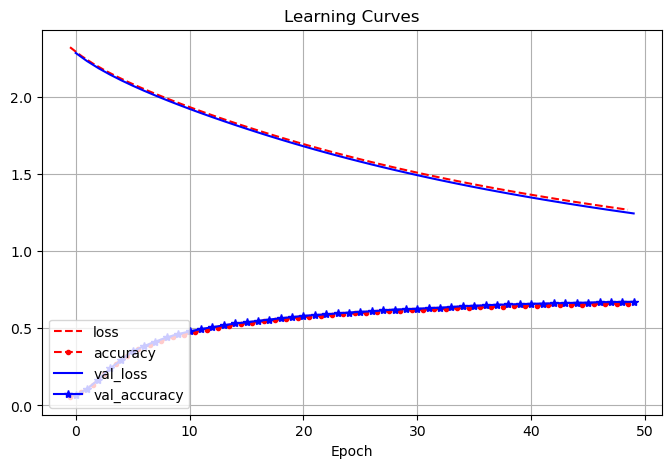

In [71]:
# Create function for plotting learning curves
import numpy as np
import matplotlib.pyplot as plt

def plot_curves(history):
    plt.figure(figsize=(8, 5))
    for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
        epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
        plt.plot(epochs, history.history[key], style, label=key)
    plt.xlabel("Epoch")
    plt.legend(loc="lower left")
    plt.title("Learning Curves")
    plt.grid()
    plt.show()

# Plot curves
plot_curves(history)

Use the following code to obtain the accuracy and loss of the best model saved during training (using validation data). Since we are experimenting with different hyperparameters we do not use the test data.

In [33]:
# Load best model from training
saved_model = keras.models.load_model(name_model)

# Evaluate on the validation data (don't use test data if you are comparing different hyperparameters)
saved_model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.8912


[0.30361559987068176, 0.8912000060081482]

## Learning Rate Schedulers

Learning rate schedulers can be used to vary the learning rate during training. The logic is to start with a higher learning rate that then decreasing it as training progresses so that in the beginning of training the optimiser makes bigger steps and then reduces these steps as training approaches a solution. Scheduling the learning rate can lead to much faster training and can avoid the disadvantages of both a fixed high and small learning rate.

First create a function to visualise how the learning rate will change during training.

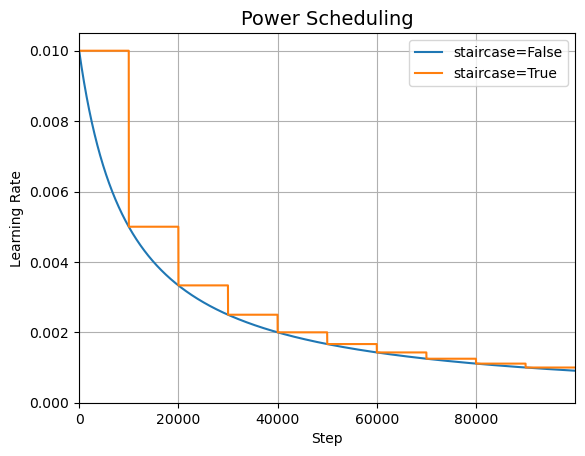

In [72]:
# Create function for plotting how the learning rate changes with Power Scheduling
import numpy as np
import matplotlib.pyplot as plt 

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Now let's use Keras' functionality to create a learning rate scheduler. We then pass this scheduler directly to the optimiser object.

In [73]:
# Create learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)

# Pass it to optimiser algorithm
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

Let's create and train the model using the same function we have defined above.

In [74]:
# Build and train model using specific hyperparameters
[model, history] = build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=opt, i_shape=[28, 28], epochs=50, call_backs=[early_stopping, best_model])

Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7269 - accuracy: 0.7632 - val_loss: 0.5072 - val_accuracy: 0.8278
Epoch 2/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4911 - accuracy: 0.8300 - val_loss: 0.4638 - val_accuracy: 0.8350
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4496 - accuracy: 0.8441 - val_loss: 0.4267 - val_accuracy: 0.8534
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4273 - accuracy: 0.8525 - val_loss: 0.4090 - val_accuracy: 0.8572
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4099 - accuracy: 0.8580 - val_loss: 0.4072 - val_accuracy: 0.8586
Epoch 6/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3966 - accuracy: 0.8621 - val_loss: 0.4087 - val_accuracy: 0.8582
Epoch 7/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3868 - accuracy: 0.8655 - val_loss: 0.3899 - val_accuracy:

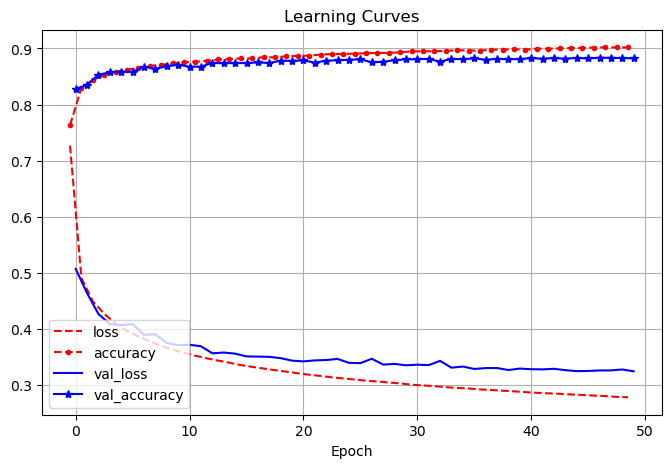

In [76]:
# Plot learning curves
plot_curves(history)

In [77]:
# Load best model from training
saved_model = keras.models.load_model(name_model)

# Evaluate on the validation data (don't use test data if you are comparing different hyperparameters)
saved_model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3247 - accuracy: 0.8824


[0.32470303773880005, 0.8823999762535095]

Finally, try a different scheduling function, such as exponential scheduling. You can first plot the actual learning rate function during training and then repeat the same steps as above for training and evaluating the neural network.

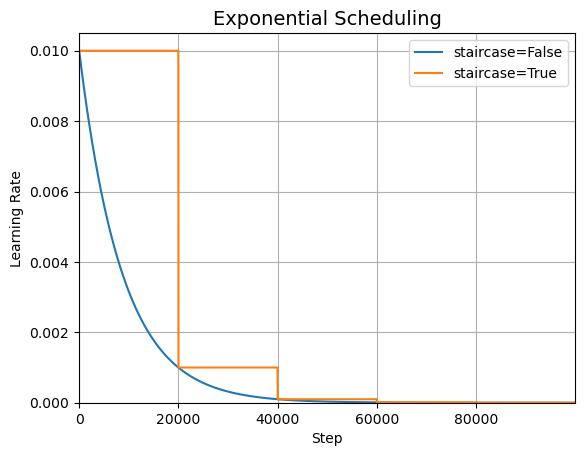

In [78]:
# Plot the exponential decay learning rate scheduler function
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [79]:
# Define exponential decay learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=0.1,
    staircase=False
)

# Create optimiser object with learning rate scheduler
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [80]:
# Build and train model using specific hyperparameters
[model, history] = build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=opt, i_shape=[28, 28], epochs=50, call_backs=[early_stopping, best_model])

Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7127 - accuracy: 0.7707 - val_loss: 0.5173 - val_accuracy: 0.8254
Epoch 2/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4953 - accuracy: 0.8302 - val_loss: 0.4674 - val_accuracy: 0.8372
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4572 - accuracy: 0.8421 - val_loss: 0.4400 - val_accuracy: 0.8444
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4394 - accuracy: 0.8489 - val_loss: 0.4303 - val_accuracy: 0.8454
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4283 - accuracy: 0.8531 - val_loss: 0.4240 - val_accuracy: 0.8508
Epoch 6/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4216 - accuracy: 0.8548 - val_loss: 0.4229 - val_accuracy: 0.8490
Epoch 7/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4173 - accuracy: 0.8559 - val_loss: 0.4172 - val_accuracy:

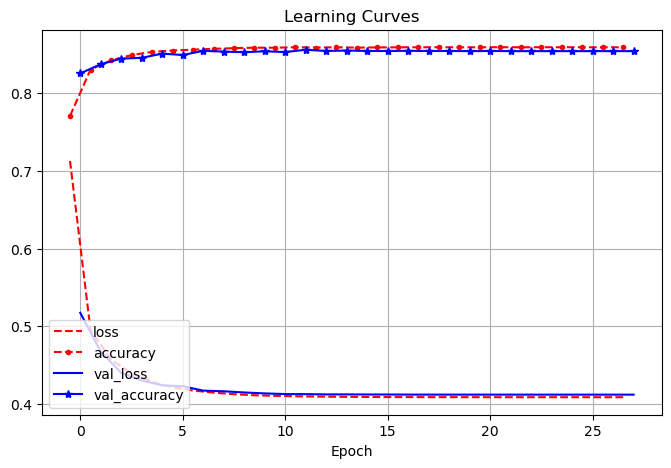

In [81]:
# Plot learning curves
plot_curves(history)

In [82]:
# Load best model from training
saved_model = keras.models.load_model(name_model)

# Evaluate on the validation data (don't use test data if you are comparing different hyperparameters)
saved_model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3247 - accuracy: 0.8824


[0.32470303773880005, 0.8823999762535095]